# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.


#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {64, 128, 256, 512, 1024}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.

This might take a while to run, so plan your time carefully.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# Import the functions from common_utils.py
from common_utils import loss_fn, intialise_loaders, MLP, EarlyStopper

2.Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [3]:
# Define the custom functions to split and preprocess the dataset for K-Fold Cross Validation

# Custom function to split the dataset for K-Fold Cross Validation, first split then fit the label encoder to the training set and transform the test set
def split_dataset(df, columns_to_drop, test_size, random_state):
    # Split the dataset into training and testing datasets
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # Define the label encoder
    label_encoder = preprocessing.LabelEncoder()

    # Fit and transform the training set, transform the test set
    df_train['label'] = label_encoder.fit_transform(df_train['label'])
    df_test['label'] = label_encoder.transform(df_test['label'])

    # Drop the columns from the training and testing datasets
    df_train2 = df_train.drop(columns_to_drop,axis=1)
    y_train2 = df_train['label'].to_numpy()

    # Drop the columns from the training and testing datasets
    df_test2 = df_test.drop(columns_to_drop,axis=1)
    y_test2 = df_test['label'].to_numpy() 

    return df_train2, y_train2, df_test2, y_test2

# Custom function to preprocess the dataset for K-Fold Cross Validation
def preprocess(df):
    drop_columns = ['filename', 'label']  # Columns to be dropped from the dataframe
    X_train, y_train, X_test, y_test = split_dataset(df, drop_columns, test_size=0.25, random_state=0)  # Split the dataset with test_size=0.25 to achieve 75:25 train-test ratio
    # Skip the scaling step as we will scale the datasets based on the new training set in the function generate_cv_folds_for_batch_sizes
    return X_train, y_train, X_test, y_test

In [4]:
# Define the function to generate the training and validation datasets for the different batch sizes
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train, X_test, y_test):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # Define the number of folds
    no_folds = 5
    
    # Define the dictionaries to store the training and validation datasets
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    X_test_scaled_dict = {}  # Define the dictionary to store the test datasets because we will need to scale them based on the new training set (we will not use the test set in this question, this is only for consistency)
    y_train_dict = {}
    y_val_dict = {}
    y_test_dict = {}  # Define the dictionary to store the test dataset labels (we will not use the test set in this question, this is only for consistency)
    
    # Define the k-fold cross-validation
    kf = KFold(n_splits=no_folds, shuffle=True, random_state=0)
    
    # Loop through the different batch sizes
    for batch_size in parameters:
        # Set the initial list value to the dictionaries
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        X_test_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []
        y_test_dict[batch_size] = []
        
        # Loop through the different folds
        for train_index, val_index in kf.split(X_train):
            # For every batch size, iterate through the different folds that split the dataset into training and validation datasets
            X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]  # Split the training and validation datasets with the features
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]  # Split the training and validation datasets with the labels
            
            X_test_fold = X_test  # Get the test dataset
            y_test_fold = y_test  # Get the test dataset labels
            
            # Scale the input features
            scaler = preprocessing.StandardScaler()
            X_train_fold = scaler.fit_transform(X_train_fold)  # Fit and transform the training set
            X_val_fold = scaler.transform(X_val_fold)  # Apply the scaling based on the training set to the validation set
            X_test_fold = scaler.transform(X_test_fold)  # Apply the scaling based on the training set to the test set (we will not use the test set in this question, this is only for consistency)
            
            
            # Append the training and validation datasets to the dictionaries
            X_train_scaled_dict[batch_size].append(X_train_fold)
            X_val_scaled_dict[batch_size].append(X_val_fold)
            X_test_scaled_dict[batch_size].append(X_test_fold)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)
            y_test_dict[batch_size].append(y_test_fold)
            
    
    return X_train_scaled_dict, X_val_scaled_dict, X_test_scaled_dict, y_train_dict, y_val_dict, y_test_dict

In [5]:
# Load the dataset
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

# Preprocess the dataset
X_train, y_train, X_test, y_test = preprocess(df)

In [6]:
# Define the batch sizes
batch_sizes = [64, 128, 256, 512, 1024]
# Generate the training and validation datasets
X_train_scaled_dict, X_val_scaled_dict, X_test_scaled_dict, y_train_dict, y_val_dict, y_test_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train, X_test.to_numpy(), y_test)

In [7]:
# Analyse the shape of the training and validation datasets
for batch_size in batch_sizes:
    print(f'Batch Size: {batch_size}')
    print(f'X_train_scaled: {X_train_scaled_dict[batch_size][0].shape}')
    print(f'X_val_scaled: {X_val_scaled_dict[batch_size][0].shape}')
    print(f'X_test_scaled: {X_test_scaled_dict[batch_size][0].shape}')
    print(f'y_train: {y_train_dict[batch_size][0].shape}')
    print(f'y_val: {y_val_dict[batch_size][0].shape}')
    print(f'y_test: {y_test_dict[batch_size][0].shape}')
    print()
    

Batch Size: 64
X_train_scaled: (7233, 77)
X_val_scaled: (1809, 77)
X_test_scaled: (3015, 77)
y_train: (7233,)
y_val: (1809,)
y_test: (3015,)

Batch Size: 128
X_train_scaled: (7233, 77)
X_val_scaled: (1809, 77)
X_test_scaled: (3015, 77)
y_train: (7233,)
y_val: (1809,)
y_test: (3015,)

Batch Size: 256
X_train_scaled: (7233, 77)
X_val_scaled: (1809, 77)
X_test_scaled: (3015, 77)
y_train: (7233,)
y_val: (1809,)
y_test: (3015,)

Batch Size: 512
X_train_scaled: (7233, 77)
X_val_scaled: (1809, 77)
X_test_scaled: (3015, 77)
y_train: (7233,)
y_val: (1809,)
y_test: (3015,)

Batch Size: 1024
X_train_scaled: (7233, 77)
X_val_scaled: (1809, 77)
X_test_scaled: (3015, 77)
y_train: (7233,)
y_val: (1809,)
y_test: (3015,)



In [8]:
# Show the different validation datasets for the different folds and batch sizes
for batch_size in batch_sizes:
    print(f'Batch Size: {batch_size}')
    for fold in range(5):
        print(f'Fold {fold + 1}')
        print(f'X_val_scaled: {X_val_scaled_dict[batch_size][fold]}')
        print()

Batch Size: 64
Fold 1
X_val_scaled: [[ 0.23612302 -0.61347715 -0.69060688 ... -0.50546538 -0.48553459
  -0.71808041]
 [ 0.93082426  0.06454943  0.05118705 ... -0.30486283  0.32826456
  -0.22472581]
 [ 0.93082426  2.41577774  1.59996537 ... -0.35988366  1.24961347
  -0.60530999]
 ...
 [ 0.44331462 -0.6176734  -0.3623915  ... -0.89574596  0.50431446
  -0.39887342]
 [-0.41998372  1.59772874  1.67225898 ... -0.27814984  1.27130334
  -0.25450459]
 [ 0.44331462  1.94358855  2.27107858 ... -0.24701959 -0.58441223
  -0.51415245]]

Fold 2
X_val_scaled: [[-0.28876988 -0.61320603 -0.60660577 ...  0.41265444 -1.09167259
   0.21435087]
 [-0.56101922 -0.74129755 -0.86458033 ... -0.37838069 -1.6669896
   0.29265984]
 [ 0.65654035 -0.09887603  0.07071657 ...  3.12704201  0.19027812
   2.57486998]
 ...
 [-0.79293533 -0.76202787 -0.72036832 ... -0.06765441 -0.54514217
  -0.24868852]
 [-0.56101922 -0.20449152  0.12862173 ... -0.07010232  0.06787938
  -0.16212107]
 [-0.56101922 -0.75002611 -0.79280662 ...

3.Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [9]:
# Define the function to find the optimal hyperparameter
def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, parameter_name):
    # Define the dictionaries to store the mean cross-validation accuracies and the time taken to train the network on the last epoch for the different batch sizes
    cross_validation_accuracies = {}
    cross_validation_times = {}
    cross_validation_losses = {}

    # Define the variables from QA1
    no_epochs = 100  # Define the number of epochs
    no_folds = 5  # Define the number of folds
    learning_rate = 0.001  # Learning rate for the optimizer
    patience = 3  # Patience for the early stopper
    no_hidden = 128  # Number of neurons in each hidden layer
    no_labels = 1  # Number of output labels
    
    # Loop through the different batch sizes
    for batch_size in batch_sizes:
        # Define the lists to store the cross-validation accuracies, losses and the time taken to train the network on the last epoch for the current batch size
        batch_size_accuracies = []
        batch_size_times = []
        batch_size_losses = []
        
        # Define the number of features
        no_features = X_train_scaled_dict[batch_size][0].shape[1]
        
        # Print the current batch size
        print(f'Batch Size: {batch_size}')
        
        # Loop through the different folds
        for fold in range(no_folds):
            # Define the training and validation datasets
            X_train = X_train_scaled_dict[batch_size][fold]
            X_val = X_val_scaled_dict[batch_size][fold]
            y_train = y_train_dict[batch_size][fold]
            y_val = y_val_dict[batch_size][fold]
            
            # Define the dataloaders
            train_dataloader, val_dataloader = intialise_loaders(X_train, y_train, X_val, y_val, batch_size)
            
            # Define the model
            model = MLP(no_features, no_hidden, no_labels)
            
            # Define the optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            
            # Define the early stopper
            early_stopper = EarlyStopper(patience=patience)
            
            # Train the model
            for epoch in range(no_epochs):
                # Start the timer
                start_time = time.time()
                # Set the model to train mode
                model.train()
                # Loop through the mini-batches and train the model
                for X_batch, y_batch in train_dataloader:
                    optimizer.zero_grad()  # Zero the gradients
                    y_pred = model(X_batch)  # Perform a forward pass of the model
                    loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
                    loss.backward()  # Backpropagate the gradients
                    optimizer.step()  # Update the model parameters
                
                # Set the model to evaluation mode
                model.eval()
                # Define the variables to store the training and validation accuracy and loss values
                val_loss, val_accuracy = 0, 0  # Define variables to store the loss and accuracy values for the validation dataset
                val_no_batches = len(val_dataloader)  # Define the number of mini-batches in the val dataset
                val_size = len(val_dataloader.dataset) # Define the size of the dataset
                # Disable gradient computation using the no_grad context, reducing memory consumption
                with torch.no_grad():
                    # Compute the validation accuracy and loss
                    for X_batch, y_batch in val_dataloader:
                        y_pred = model(X_batch)  # Perform a forward pass of the model
                        loss = loss_fn(y_pred, y_batch)  # Compute the loss value between the predictions and the actual target values
                        
                        # Compute the validation accuracy and loss for the current batch
                        val_loss += loss.item()  # Add the loss value to the running total
                        val_accuracy += ((y_pred > 0.5) == y_batch).sum().item()  # Compute the number of correctly classified samples and add to the running total
                    
                # Compute the average validation accuracy and loss values
                val_accuracy /= val_size  # Compute the average validation accuracy
                val_loss /= val_no_batches  # Compute the average validation loss
                    
                if early_stopper.early_stop(val_loss): 
                    end_time = time.time()  # Stop the timer
                    # Append the time, accuracies and losses (done for the early stopper only because we are interested in the time taken to train the network on the last epoch)
                    batch_size_times.append(end_time - start_time)  # Append the time taken to train the network on the last epoch
                    batch_size_accuracies.append(val_accuracy)  # Append the validation accuracy for the last epoch
                    batch_size_losses.append(val_loss)  # Append the validation loss for the last epoch
                    # Print the results for the current fold
                    print(f"Batch size {batch_size}, Fold {fold + 1}, Epoch stopped at {epoch + 1} with validation loss: {val_loss:.4f} and validation accuracy: {val_accuracy:.4f}")
                    break
        
        # Compute the mean cross-validation accuracy, loss and the time taken to train the network on the last epoch for the current batch size
        cross_validation_accuracies[batch_size] = np.mean(batch_size_accuracies)
        cross_validation_times[batch_size] = np.mean(batch_size_times)
        cross_validation_losses[batch_size] = np.mean(batch_size_losses)
        
    # Return the mean cross-validation accuracies, losses and the time taken to train the network on the last epoch for the different batch sizes
    return cross_validation_accuracies, cross_validation_times, cross_validation_losses
        

batch_sizes = [64, 128, 256, 512, 1024]
cross_validation_accuracies, cross_validation_times, cross_validation_losses = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')

Batch Size: 64
Batch size 64, Fold 1, Epoch stopped at 22 with validation loss: 0.5487 and validation accuracy: 0.7363
Batch size 64, Fold 2, Epoch stopped at 30 with validation loss: 0.5502 and validation accuracy: 0.7474
Batch size 64, Fold 3, Epoch stopped at 24 with validation loss: 0.5243 and validation accuracy: 0.7461
Batch size 64, Fold 4, Epoch stopped at 25 with validation loss: 0.5293 and validation accuracy: 0.7445
Batch size 64, Fold 5, Epoch stopped at 26 with validation loss: 0.5576 and validation accuracy: 0.7412
Batch Size: 128
Batch size 128, Fold 1, Epoch stopped at 17 with validation loss: 0.5351 and validation accuracy: 0.7336
Batch size 128, Fold 2, Epoch stopped at 14 with validation loss: 0.5736 and validation accuracy: 0.6877
Batch size 128, Fold 3, Epoch stopped at 28 with validation loss: 0.5109 and validation accuracy: 0.7544
Batch size 128, Fold 4, Epoch stopped at 25 with validation loss: 0.5332 and validation accuracy: 0.7351
Batch size 128, Fold 5, Epoch

4.Plot scatterplot of mean cross validation accuracies for the different batch sizes.

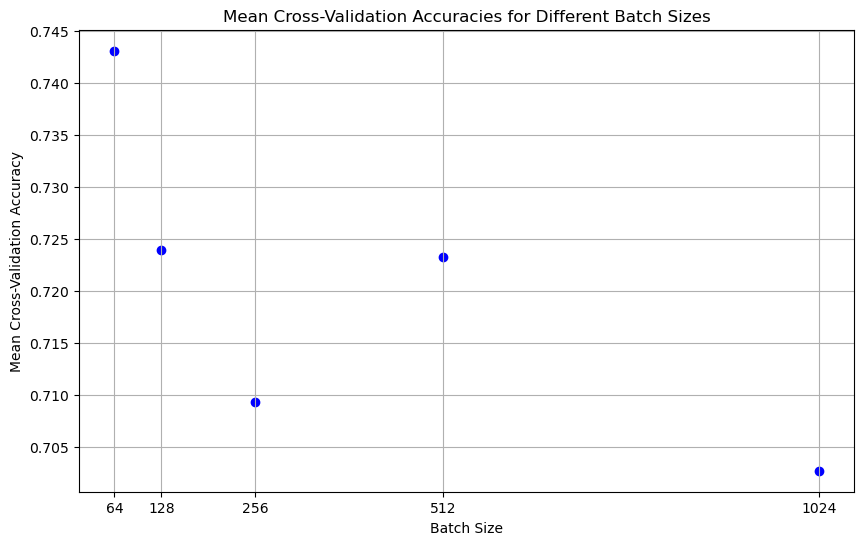

In [10]:
# Plot the scatterplot of mean cross-validation accuracies (for the last epoch) for the different batch sizes
plt.figure(figsize=(10, 6))
plt.scatter(cross_validation_accuracies.keys(), cross_validation_accuracies.values(), color='blue')
plt.title('Mean Cross-Validation Accuracies for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.xticks(ticks=batch_sizes, labels = [str(batch_size) for batch_size in batch_sizes])
plt.ylabel('Mean Cross-Validation Accuracy')
plt.grid(True)
plt.show()

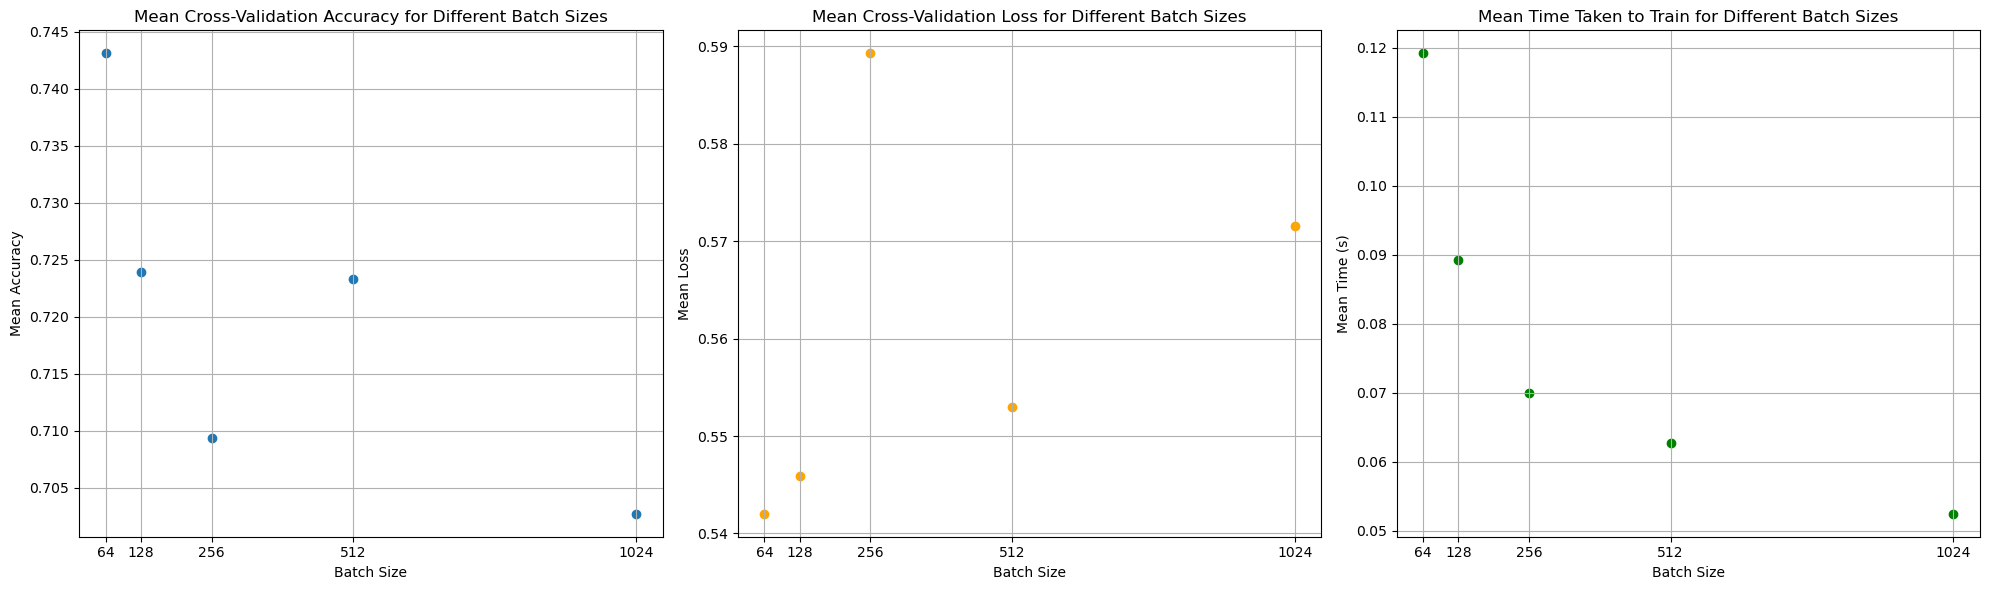

In [11]:
# Plot the 3 plots for the mean cross-validation accuracies, losses (on the final epoch) and the time taken to train the network on the last epoch for the different batch sizes
plt.figure(figsize=(20, 6))

# Plot mean cross-validation accuracy for different batch sizes
plt.subplot(1, 3, 1)
plt.scatter(list(cross_validation_accuracies.keys()), list(cross_validation_accuracies.values()), marker='o')
plt.title('Mean Cross-Validation Accuracy for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.xticks(ticks=batch_sizes, labels = [str(batch_size) for batch_size in batch_sizes])
plt.ylabel('Mean Accuracy')
plt.grid(True)

# Plot mean cross-validation loss for different batch sizes
plt.subplot(1, 3, 2)
plt.scatter(list(cross_validation_losses.keys()), list(cross_validation_losses.values()), marker='o', color='orange')
plt.title('Mean Cross-Validation Loss for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.xticks(ticks=batch_sizes, labels = [str(batch_size) for batch_size in batch_sizes])
plt.ylabel('Mean Loss')
plt.grid(True)

# Plot mean time taken to train for different batch sizes
plt.subplot(1, 3, 3)
plt.scatter(list(cross_validation_times.keys()), list(cross_validation_times.values()), marker='o', color='green')
plt.title('Mean Time Taken to Train for Different Batch Sizes')
plt.xlabel('Batch Size')
plt.xticks(ticks=batch_sizes, labels = [str(batch_size) for batch_size in batch_sizes])
plt.ylabel('Mean Time (s)')
plt.grid(True)

plt.tight_layout()
plt.show()


4.Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [12]:
df = pd.DataFrame({'Batch Size': cross_validation_times.keys(), # Get the batch sizes from the dictionary's keys
                   'Last Epoch Time': cross_validation_times.values(), # Get the time taken to train the network on the last epoch from the dictionary's values
                    'Mean Cross-Validation Accuracy': cross_validation_accuracies.values(), # Get the mean cross-validation accuracy from the dictionary's values
                    'Mean Cross-Validation Loss': cross_validation_losses.values() # Get the mean cross-validation loss from the dictionary's values
                  })

df

,Batch Size,Last Epoch Time,Mean Cross-Validation Accuracy,Mean Cross-Validation Loss
0,64,0.119206,0.743088,0.542029
1,128,0.089221,0.723958,0.545892
2,256,0.070011,0.709352,0.589269
3,512,0.062661,0.723287,0.553018
4,1024,0.052475,0.702719,0.571561


In [13]:
# Calculating the differance (in percents) between the statistics for batch size 64 and 128
print('Computed in percents with respect to batch size 64')
print(f"Mean Cross-Validation Accuracy difference between batch size 64 and 128: {(cross_validation_accuracies[64] - cross_validation_accuracies[128]) / cross_validation_accuracies[64] * 100:.2f}%")
print(f"Mean Cross-Validation Loss difference between batch size 64 and 128: {(cross_validation_losses[64] - cross_validation_losses[128]) / cross_validation_losses[64] * 100:.2f}%")
print(f"Mean Time Taken to Train difference between batch size 64 and 128: {(cross_validation_times[64] - cross_validation_times[128]) / cross_validation_times[64] * 100:.2f}%")

Computed in percents with respect to batch size 64
Mean Cross-Validation Accuracy difference between batch size 64 and 128: 2.57%
Mean Cross-Validation Loss difference between batch size 64 and 128: -0.71%
Mean Time Taken to Train difference between batch size 64 and 128: 25.15%


In [14]:
# Select the optimal batch size
optimal_batch_size = 64 
reason = """
Despite the fact that the larger batch sizes achieve better training times on the last epoch, the batch size with the highest mean cross-validation accuracy is the batch size of 64. Also, the larger batch sizes may take less time on their final epoch but we should also consider the fact that they may require more epochs to converge. From the results of the hyperparameter tuning, we can see that the batch sizes of 1024 and 512 have the lowest time but also take more than 40 epochs to converge for some of the folds. If we compare the batch sizes of 64 (highest accuracy and lowest loss) and 128 (second best), we can see that batch size 128 achieves faster time on the last epoch but the result is more than 2.5% lower than the one achieved for batch size 64. Since no other batch size achieves similar accuracy to the batch size of 64, we can conclude that the batch size of 64 is the optimal batch size for the dataset.
"""
print(f'Optimal Batch Size: {optimal_batch_size}\n')
print(f'Reason:{reason}')

Optimal Batch Size: 64

Reason:
Despite the fact that the larger batch sizes achieve better training times on the last epoch, the batch size with the highest mean cross-validation accuracy is the batch size of 64. Also, the larger batch sizes may take less time on their final epoch but we should also consider the fact that they may require more epochs to converge. From the results of the hyperparameter tuning, we can see that the batch sizes of 1024 and 512 have the lowest time but also take more than 40 epochs to converge for some of the folds. If we compare the batch sizes of 64 (highest accuracy and lowest loss) and 128 (second best), we can see that batch size 128 achieves faster time on the last epoch but the result is more than 2.5% lower than the one achieved for batch size 64. Since no other batch size achieves similar accuracy to the batch size of 64, we can conclude that the batch size of 64 is the optimal batch size for the dataset.



In [15]:
comment = """
Before implementing the current approach for splitting and scaling the data (split train & test; split train to train and validation for k-fold; scale features all together for train, validation, test), I first split the dataset into train and test, performed the feature scaling, and then form the k-folds for train and validation and scale again, in this the previous method we get the training subset for the k-fold split by scaling the already scaled initial whole training dataset from the train/test initial split. Using my previous approach I got almost the same results but the accuracy for all batch sizes was lower by 1-2% and because of this we could have considered 128 as an optimal batch size because the difference between 64 and 128 was not so significant but still 128 was taking much less time on the final epoch. This is a good example of how the preprocessing can affect the results and how important it is to choose the right approach for the dataset. However, the previous approach can cause inconsistency if we want the 3 datasets separately (if later we are not combining training and validation sets for the final model training). Also, we get the k-fold train dataset by fitting and transforming the already scaled initial training dataset, because of this I decided to use the current approach. In my opinion, the current approach is more similar to the real-world scenario where we have only one dataset and we want to use it for training, validation and testing.
"""
print(comment)


Before implementing the current approach for splitting and scaling the data (split train & test; split train to train and validation for k-fold; scale features all together for train, validation, test), I first split the dataset into train and test, performed the feature scaling, and then form the k-folds for train and validation and scale again, in this the previous method we get the training subset for the k-fold split by scaling the already scaled initial whole training dataset from the train/test initial split. Using my previous approach I got almost the same results but the accuracy for all batch sizes was lower by 1-2% and because of this we could have considered 128 as an optimal batch size because the difference between 64 and 128 was not so significant but still 128 was taking much less time on the final epoch. This is a good example of how the preprocessing can affect the results and how important it is to choose the right approach for the dataset. However, the previous appr